
## 😣 **Labor Market Distress**

*Signals slack, hardship, and rising involuntary unemployment — from early shocks to persistent labor force detachment.*
**Frequency:** Monthly

| Indicator                                           | Source                        | Notes                                                            |
| --------------------------------------------------- | ----------------------------- | ---------------------------------------------------------------- |
| Unemployment Rate (U-3)                             | BLS (`UNRATE`)                | Headline unemployment, captures active jobseekers                |
| Unemployment Rate (U-6)                             | BLS (`U6RATE`)                | Broader measure incl. discouraged and underemployed              |
| Unemployment Rate (U-2)                             | BLS (`U2RATE`)                | Job losers and temp job completers; early distress signal        |
| Initial Jobless Claims                              | FRED (`ICSA`)                 | Weekly flow of new unemployment claims                           |
| Continued Jobless Claims                            | FRED (`CCSA`)                 | Signals persistent unemployment conditions                       |
| Median Weeks Unemployed                             | BLS (`UEMPMED`)               | Duration of joblessness; hardship signal                         |
| Long-term Unemployed Share                          | Derived (UEMP27OV / UNEMPLOY) | Share of unemployed without work for 27+ weeks                   |
| Part-Time for Economic Reasons                      | BLS (`LNS12032194`)           | Involuntary part-time workers                                    |
| Not in Labor Force – Want a Job Now                 | FRED (`NILFWJN`)              | Broad group who want work but are not searching                  |
| Marginally Attached (Want Job Now, Recently Looked) | BLS (`LNU05026645`)           | Subset of NILFWJN; looked in past 12 months but not last 4 weeks |
| Insured Unemployment Rate                           | FRED (`IURSA`)                | Unemployment claims as % of covered workforce                    |

---



In [4]:
import pandas as pd
import sqlite3

# Load CSV files into DataFrames
U3_Unemployment_Rate_df = pd.read_csv('U3_Unemployment_Rate.csv')
U6_Unemployment_Rate_df = pd.read_csv('U6_Unemployment_Rate.csv')
U2_Unemployment_Rate_df = pd.read_csv('U2_Unemployment_Rate.csv')
Initial_Jobless_Claims_df = pd.read_csv('Initial_Jobless_Claims.csv')
Continued_Jobless_Claims_df = pd.read_csv('Continued_Jobless_Claims.csv')
Median_Weeks_Unemployed_df = pd.read_csv('Median_Weeks_Unemployed.csv')
Unemployed_27_Weeks_or_More_df = pd.read_csv('Unemployed_27_Weeks_or_More.csv')
Part_Time_for_Economic_Reasons_df = pd.read_csv('Part_Time_for_Economic_Reasons.csv')
NILFWJN_df = pd.read_csv('NILFWJN.csv')
Mariginally_Attached_NILFWJN_df = pd.read_csv('Marginally_Attached_NILFWJN.csv')
Insured_Unemployment_Rate_df = pd.read_csv('Insured_Unemployment_Rate.csv')
Unemployment_Level_df= pd.read_csv('Unemployment_Level.csv')
Employment_Level_df= pd.read_csv('Employment_Level.csv') 
Not_in_Labor_Force_df = pd.read_csv('Not_in_Labor_Force.csv')





# Create an SQLite in-memory database
conn = sqlite3.connect(':memory:')

# Load DataFrames into the database as tables
U3_Unemployment_Rate_df.to_sql('U3', conn, index=False, if_exists='replace')
U6_Unemployment_Rate_df.to_sql('U6', conn, index=False, if_exists='replace')
U2_Unemployment_Rate_df.to_sql('U2', conn, index=False, if_exists='replace')
Initial_Jobless_Claims_df.to_sql('Initial_Jobless_Claims', conn, index=False, if_exists='replace')
Continued_Jobless_Claims_df.to_sql('Continued_Jobless_Claims', conn, index=False, if_exists='replace')
Median_Weeks_Unemployed_df.to_sql('Median_Weeks_Unemployed', conn, index=False, if_exists='replace')
Unemployed_27_Weeks_or_More_df.to_sql('Unemployed_27', conn, index=False, if_exists='replace')
Part_Time_for_Economic_Reasons_df.to_sql('Part_Time', conn, index=False, if_exists='replace')
NILFWJN_df.to_sql('Finding_Job', conn, index=False, if_exists='replace')
Mariginally_Attached_NILFWJN_df.to_sql('Marginally_Attached', conn, index=False, if_exists='replace')
Insured_Unemployment_Rate_df.to_sql('Insured_Unemployment', conn, index=False, if_exists='replace')
Unemployment_Level_df.to_sql('Unemployment_Level', conn, index=False, if_exists='replace')
Employment_Level_df.to_sql('Employment_Level', conn, index=False, if_exists='replace')
Not_in_Labor_Force_df.to_sql('Not_in_Labor_Force', conn, index=False, if_exists='replace')


# SQL query to merge all tables on 'Player'
sql_query = """
SELECT 
    Finding_Job.observation_date, 
    UNRATE as "U3_Unemployment_Rate",
    U6RATE as "U6_Unemployment_Rate",
    U2RATE as "U2_Unemployment_Rate",
    ICSA as "Initial_Claims",
    CCSA as "Continued_Claims",
    UEMPMED as "Median_Weeks_Unemployed",
    UEMP27OV as "Unemployed_27Weeks_or_More",
    LNS12032194 as "Part_Time_for_Economic_Reasons",
    NILFWJN as "NILFWJN",
    LNS15000000 as "Not_in_Labor_Force",
    LNU05026645 as "Marginally_Attached",
    IURSA as "Insured_Unemployment_Rate",
    UNEMPLOY as "Unemployed",
    CE16OV as "Employed"

FROM Finding_Job
INNER JOIN U3 ON Finding_Job.observation_date = U3.observation_date
INNER JOIN U6 ON Finding_Job.observation_date = U6.observation_date
INNER JOIN U2 ON Finding_Job.observation_date = U2.observation_date
INNER JOIN Initial_Jobless_Claims ON Finding_Job.observation_date = Initial_Jobless_Claims.observation_date
INNER JOIN Continued_Jobless_Claims ON Finding_Job.observation_date = Continued_Jobless_Claims.observation_date
INNER JOIN Median_Weeks_Unemployed ON Finding_Job.observation_date = Median_Weeks_Unemployed.observation_date
INNER JOIN Unemployed_27 ON Finding_Job.observation_date = Unemployed_27.observation_date
INNER JOIN Part_Time ON Finding_Job.observation_date = Part_Time.observation_date
INNER JOIN Marginally_Attached ON Finding_Job.observation_date = Marginally_Attached.observation_date
INNER JOIN Not_in_Labor_Force ON Finding_Job.observation_date = Not_in_Labor_Force.observation_date
INNER JOIN Insured_Unemployment ON Finding_Job.observation_date = Insured_Unemployment.observation_date
INNER JOIN Unemployment_Level ON Finding_Job.observation_date = Unemployment_Level.observation_date
INNER JOIN Employment_Level ON Finding_Job.observation_date = Employment_Level.observation_date

"""


# Execute the query and load results into a DataFrame
Labor_Market_Distress_df = pd.read_sql_query(sql_query, conn)

# Save the merged DataFrame to a new CSV file
# csv_filename = "Stats/All_Player_Numbers.csv"
# Player_Numbers_df.to_csv(csv_filename, index=False)

# Close the connection
conn.close()

# Provide the file to the user


Labor_Market_Distress_df

,observation_date,U3_Unemployment_Rate,U6_Unemployment_Rate,U2_Unemployment_Rate,Initial_Claims,Continued_Claims,Median_Weeks_Unemployed,Unemployed_27Weeks_or_More,Part_Time_for_Economic_Reasons,NILFWJN,Not_in_Labor_Force,Marginally_Attached,Insured_Unemployment_Rate,Unemployed,Employed
0,1994-01-01,6.6,11.7,3.3,359200.0,2709600,8.6,1733,4947,6723,65357,600,2.6,8630,121966
1,1994-02-01,6.6,11.4,3.2,348500.0,2792500,9.2,1759,4677,6315,65421,489,2.6,8583,122086
2,1994-03-01,6.5,11.5,3.1,335750.0,2754500,9.3,1780,4890,6387,65813,533,2.6,8470,121930
3,1994-04-01,6.4,11.3,2.9,344000.0,2736600,9.1,1746,4752,6636,65742,502,2.6,8331,122290
4,1994-05-01,6.1,10.9,2.7,359000.0,2752750,9.2,1696,4836,6363,65731,436,2.6,7915,122864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,2024-12-01,4.1,7.5,1.9,222250.0,1860750,10.4,1551,4358,5505,101091,491,1.2,6886,161661
372,2025-01-01,4.0,7.5,1.9,213500.0,1865250,10.4,1443,4477,5479,101941,630,1.2,6849,163895
373,2025-02-01,4.1,8.0,1.9,226000.0,1859750,10.0,1455,4937,5893,102487,463,1.2,7052,163307
374,2025-03-01,4.2,7.9,1.9,223200.0,1863200,9.8,1495,4780,5915,102431,458,1.2,7083,163508


# 🧠 **Feature Engineering:**

* `U6_U3_Spread = U6RATE - U3RATE`
  *Captures hidden slack beyond headline unemployment*
* `Long_Term_Unemployment_Rate = UEMP27OV / UNEMPLOY`
  *Signals duration-based labor hardship*
* `InvoluntaryPartTimeRate = LNS12032194 / Employed`
  *Quantifies underemployment and hours cutbacks*
* `NILFWJN_Ratio = NILFWJN / NotInLaborForce`
  *Captures general desire for work across non-participants*
* `MarginalAttachmentRate = LNU05026645 / NotInLaborForce`
  *Stricter labor market detachment metric*
* `MedianWeeks_Z = z-score(MedianWeeksUnemployed)`
* `U2_Z = z-score(U2RATE)`
---

In [5]:
from scipy.stats import zscore

Labor_Market_Distress_df['U6_U3_Spread'] = Labor_Market_Distress_df['U6_Unemployment_Rate'] - Labor_Market_Distress_df['U3_Unemployment_Rate']
Labor_Market_Distress_df['Long_Term_Unemployment_Rate'] = Labor_Market_Distress_df['Unemployed_27Weeks_or_More'] / Labor_Market_Distress_df['Unemployed']
Labor_Market_Distress_df['Involuntary_Part_Time_Rate'] = Labor_Market_Distress_df['Part_Time_for_Economic_Reasons'] / Labor_Market_Distress_df['Employed']
Labor_Market_Distress_df['NILFWJN_Ratio'] = Labor_Market_Distress_df['NILFWJN'] / Labor_Market_Distress_df['Not_in_Labor_Force'] 
Labor_Market_Distress_df['Marginal_Attachment_Rate'] = (Labor_Market_Distress_df['Marginally_Attached'] / Labor_Market_Distress_df['Not_in_Labor_Force'])*100
Labor_Market_Distress_df['Median_Weeks_Unemployed_ZScore'] = zscore(Labor_Market_Distress_df['Median_Weeks_Unemployed'])
Labor_Market_Distress_df['U2_z'] = zscore(Labor_Market_Distress_df['U2_Unemployment_Rate'])

Labor_Market_Distress_df.columns

Index(['observation_date', 'U3_Unemployment_Rate', 'U6_Unemployment_Rate',
       'U2_Unemployment_Rate', 'Initial_Claims', 'Continued_Claims',
       'Median_Weeks_Unemployed', 'Unemployed_27Weeks_or_More',
       'Part_Time_for_Economic_Reasons', 'NILFWJN', 'Not_in_Labor_Force',
       'Marginally_Attached', 'Insured_Unemployment_Rate', 'Unemployed',
       'Employed', 'U6_U3_Spread', 'Long_Term_Unemployment_Rate',
       'Involuntary_Part_Time_Rate', 'NILFWJN_Ratio',
       'Marginal_Attachment_Rate', 'Median_Weeks_Unemployed_ZScore', 'U2_z'],
      dtype='object')

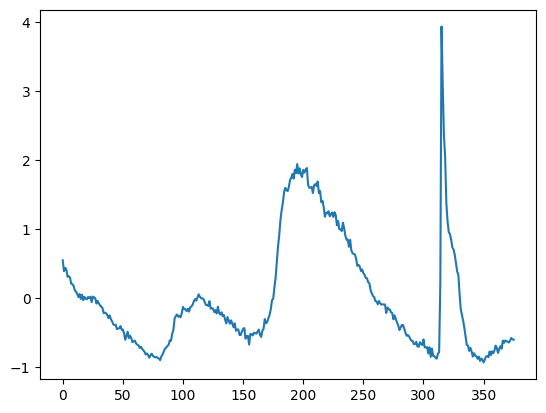

In [8]:
from scipy.stats import zscore

# Standardize key derived features
Labor_Market_Distress_df['U3_z'] = zscore(Labor_Market_Distress_df['U3_Unemployment_Rate'], nan_policy='omit')
Labor_Market_Distress_df['U6_z'] = zscore(Labor_Market_Distress_df['U6_Unemployment_Rate'], nan_policy='omit')
Labor_Market_Distress_df['InitialClaims_z'] = zscore(Labor_Market_Distress_df['Initial_Claims'], nan_policy='omit')
Labor_Market_Distress_df['ContinuedClaims_z'] = zscore(Labor_Market_Distress_df['Continued_Claims'], nan_policy='omit')
Labor_Market_Distress_df['U6_U3_Spread_z'] = zscore(Labor_Market_Distress_df['U6_U3_Spread'], nan_policy='omit')
Labor_Market_Distress_df['LongTermUnemp_z'] = zscore(Labor_Market_Distress_df['Long_Term_Unemployment_Rate'], nan_policy='omit')
Labor_Market_Distress_df['InvolPartTime_z'] = zscore(Labor_Market_Distress_df['Involuntary_Part_Time_Rate'], nan_policy='omit')
Labor_Market_Distress_df['NILFWJN_Ratio_z'] = zscore(Labor_Market_Distress_df['NILFWJN_Ratio'], nan_policy='omit')
Labor_Market_Distress_df['MarginalAttach_z'] = zscore(Labor_Market_Distress_df['Marginal_Attachment_Rate'], nan_policy='omit')

# Combine into index
Labor_Market_Distress_df['Labor_Market_Distress_Index'] = Labor_Market_Distress_df[[
    'U3_z', 'U6_z', 'U2_z',
    'InitialClaims_z', 'ContinuedClaims_z',
    'Median_Weeks_Unemployed_ZScore', 'U6_U3_Spread_z',
    'LongTermUnemp_z', 'InvolPartTime_z',
    'NILFWJN_Ratio_z', 'MarginalAttach_z'
]].mean(axis=1, skipna=True)


Labor_Market_Distress_df['Labor_Market_Distress_Index'].plot()



import os

os.makedirs('LMD', exist_ok=True)

Labor_Market_Distress_df[['observation_date', 'Labor_Market_Distress_Index']].to_csv(
    'LMD/Labor_Market_Distress_Index.csv', index=False
)
